### Feathers in Focus: AML 2025 Kaggle Challenge 🪶
### Athina Papatriantafyllou • Alexandra Holíková • Buğra Sipahioğlu

### Setup Instructions
> **Setup Commands (in terminal):**
> ```bash
> python -m venv venv
> source venv/bin/activate
> pip install -r requirements.txt
> ```
> **Download the data and unzip it under "data/raw":** https://www.kaggle.com/competitions/aml-2025-feathers-in-focus/data

### Import the Libraries

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageStat
from sklearn.model_selection import train_test_split
from torchvision.io import decode_image
from torch.utils.data import Dataset, WeightedRandomSampler
from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader
import itertools
import time
import torch
import torch.nn as nn

### Define the constants

In [20]:
# Data path constants 
DATA_DIR = "data"
TRAIN_CSV_PATH = f"{DATA_DIR}/train_images.csv"
TEST_CSV_PATH = f"{DATA_DIR}/test_images_path.csv"
CLASS_NAMES_PATH = f"{DATA_DIR}/class_names.npy"
ATTRIBUTES_PATH = f"{DATA_DIR}/attributes.npy"
ATTRIBUTES_TXT_PATH = f"{DATA_DIR}/attributes.txt"
TRAIN_IMAGES_BASE_PATH = f"{DATA_DIR}/train_images"
TEST_IMAGES_BASE_PATH = f"{DATA_DIR}/test_images"

# Dataset constants
VAL_SPLIT_RATIO = 0.2  # 20% validation 80% test for instance. 
RANDOM_STATE = 45  # Keep the same random state across runs for reproducibility
NUM_CLASSES = 200 # It's given in the Kaggle competition description, so we don't need to count it (yet it's counted in EDA part)

# Image transformation constants
IMAGE_SIZE = 224  # Final image size after transformations
RESIZE_SIZE = 256  # Size before center crop for validation/test
RANDOM_CROP_SCALE = (0.7, 1.0)  # RandomResizedCrop scale range
HORIZONTAL_FLIP_PROB = 0.5  # RandomHorizontalFlip probability
ROTATION_DEGREES = 15  # RandomRotation degrees
COLOR_JITTER_BRIGHTNESS = 0.2
COLOR_JITTER_CONTRAST = 0.25
COLOR_JITTER_SATURATION = 0.25
COLOR_JITTER_HUE = 0.15

# Normalization constants (ImageNet normalization statistics since pretrained models are usually trained on ImageNet)
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# Device constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE_CPU = 8
BATCH_SIZE_GPU = 8
BATCH_SIZE_MPS = 8
NUM_WORKERS_CPU = 0
NUM_WORKERS_GPU = 4
NUM_WORKERS_MPS = 0
PIN_MEMORY_CPU = False
PIN_MEMORY_GPU = True
PIN_MEMORY_MPS = False

### Load the data

In [3]:
# Load the training and test sets
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)
class_names = np.load(CLASS_NAMES_PATH, allow_pickle=True).item()

# Load attributes
attributes = np.load(ATTRIBUTES_PATH, allow_pickle=True)
with open(ATTRIBUTES_TXT_PATH, "r") as f:
    attribute_names = [line.strip().split(' ', 1)[1] for line in f.readlines()]

# Print the data summary
print("Loading the data....")
print(f"-Train Size: {len(train_df)} \n-Test Size: {len(test_df)} \n-Number of Classes: {len(class_names)}")
print(f"-Attributes: {len(attribute_names)} (shape: {attributes.shape if hasattr(attributes, 'shape') else 'N/A'})")


Loading the data....
-Train Size: 3926 
-Test Size: 4000 
-Number of Classes: 200
-Attributes: 312 (shape: (200, 312))


### Explore the data

Random images (with their labels)from the training set:


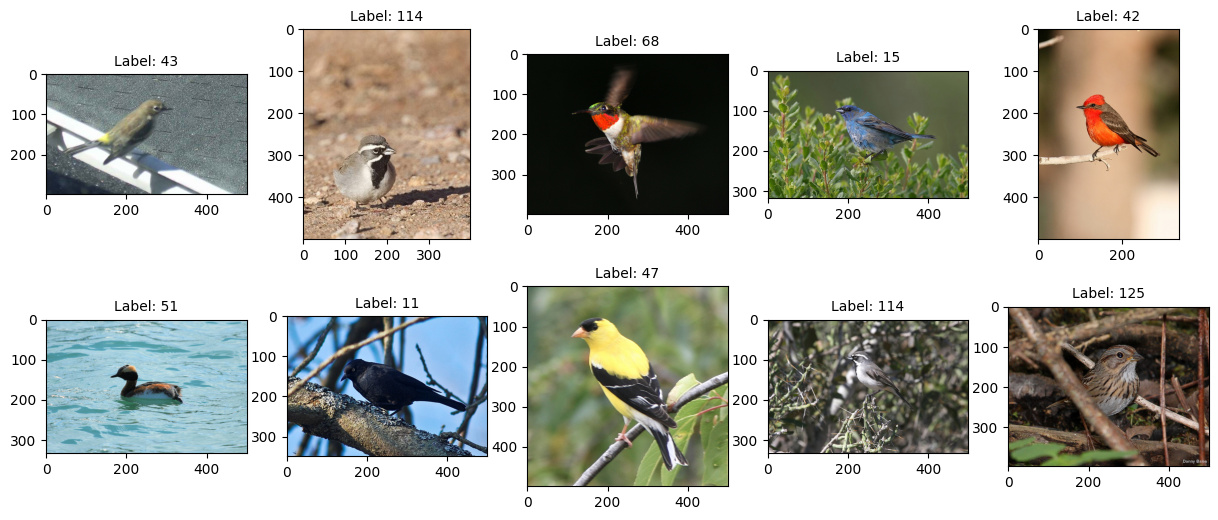

In [4]:
# Inspect the training set by showing 10 random images
print("Random images (with their labels)from the training set:")
samples = train_df.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, (_, row) in zip(axes.flat, samples.iterrows()):
    img = Image.open(f"{TRAIN_IMAGES_BASE_PATH}{row['image_path']}")
    label_name = class_names.get(row['label'], f"Label: {row['label']}")
    ax.set_title(label_name, fontsize=10)
    ax.imshow(img)
plt.show()

Checking 3926 images' dimensions: 
-Width: min=140, max=500, mean=467.78
-Height: min=120, max=500, mean=385.37


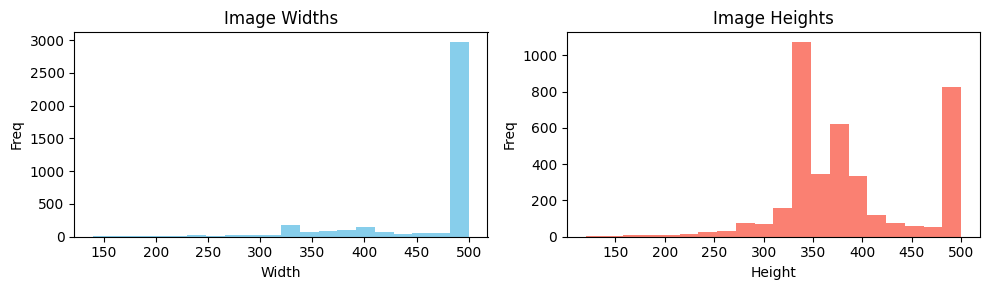

In [5]:
# Check image dimensions in the training set (concise version)
sizes = []
for p in train_df['image_path']:
    sizes.append(Image.open(f"{TRAIN_IMAGES_BASE_PATH}{p}").size)
widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]
print(f"Checking {len(widths)} images' dimensions: \n-Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.2f}\n-Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.2f}")

fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].hist(widths, bins=20, color='skyblue'), axs[0].set(title='Image Widths', xlabel='Width', ylabel='Freq')
axs[1].hist(heights, bins=20, color='salmon'), axs[1].set(title='Image Heights', xlabel='Height', ylabel='Freq')
plt.tight_layout()
plt.show()

Attributes:


,Index,Attribute Name
0,0,has_bill_shape::curved_(up_or_down)
1,1,has_bill_shape::dagger
2,2,has_bill_shape::hooked
3,3,has_bill_shape::needle
4,4,has_bill_shape::hooked_seabird
5,5,has_bill_shape::spatulate
6,6,has_bill_shape::all-purpose
7,7,has_bill_shape::cone
8,8,has_bill_shape::specialized
9,9,has_wing_color::blue


Shape of attributes: (200, 312)
Number of classes: 200
Number of attributes per class: 312

Sample attribute names (first 10):
  0: has_bill_shape::curved_(up_or_down)
  1: has_bill_shape::dagger
  2: has_bill_shape::hooked
  3: has_bill_shape::needle
  4: has_bill_shape::hooked_seabird
  5: has_bill_shape::spatulate
  6: has_bill_shape::all-purpose
  7: has_bill_shape::cone
  8: has_bill_shape::specialized
  9: has_wing_color::blue

Sample: Class 0
Attributes present (value=1):
Total: 0 out of 312
First 10: []


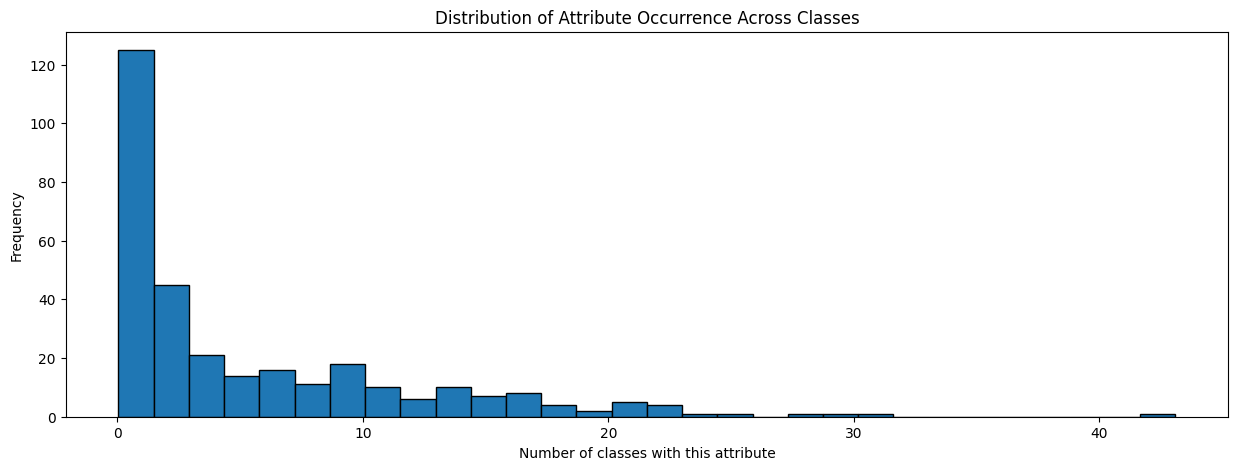


Attribute Statistics:
Min occurrences: 0.0409024614536556
Max occurrences: 43.105007530563356
Mean occurrences: 5.56
Std occurrences: 6.71


In [21]:
# Inspect the attributes
attributes_df = pd.DataFrame({'Index': range(len(attribute_names)), 'Attribute Name': attribute_names})
print("Attributes:")
display(attributes_df.head(10))
print(f"Shape of attributes: {attributes.shape}")
print(f"Number of classes: {attributes.shape[0]}")
print(f"Number of attributes per class: {attributes.shape[1]}")
print(f"\nSample attribute names (first 10):")
for i, name in enumerate(attribute_names[:10]):
    print(f"  {i}: {name}")

# Show attributes for a sample class
sample_class_idx = 0
sample_class_name = class_names.get(sample_class_idx + 1, f"Class {sample_class_idx}")
sample_attrs = attributes[sample_class_idx]

print(f"\nSample: {sample_class_name}")
print(f"Attributes present (value=1):")
present_attrs = [attribute_names[i] for i in range(len(sample_attrs)) if sample_attrs[i] == 1]
print(f"Total: {len(present_attrs)} out of {len(sample_attrs)}")
print(f"First 10: {present_attrs[:10]}")

# Visualize attribute distribution
attr_counts = attributes.sum(axis=0)
plt.figure(figsize=(15, 5))
plt.hist(attr_counts, bins=30, edgecolor='black')
plt.xlabel('Number of classes with this attribute')
plt.ylabel('Frequency')
plt.title('Distribution of Attribute Occurrence Across Classes')
plt.show()

print(f"\nAttribute Statistics:")
print(f"Min occurrences: {attr_counts.min()}")
print(f"Max occurrences: {attr_counts.max()}")
print(f"Mean occurrences: {attr_counts.mean():.2f}")
print(f"Std occurrences: {attr_counts.std():.2f}")

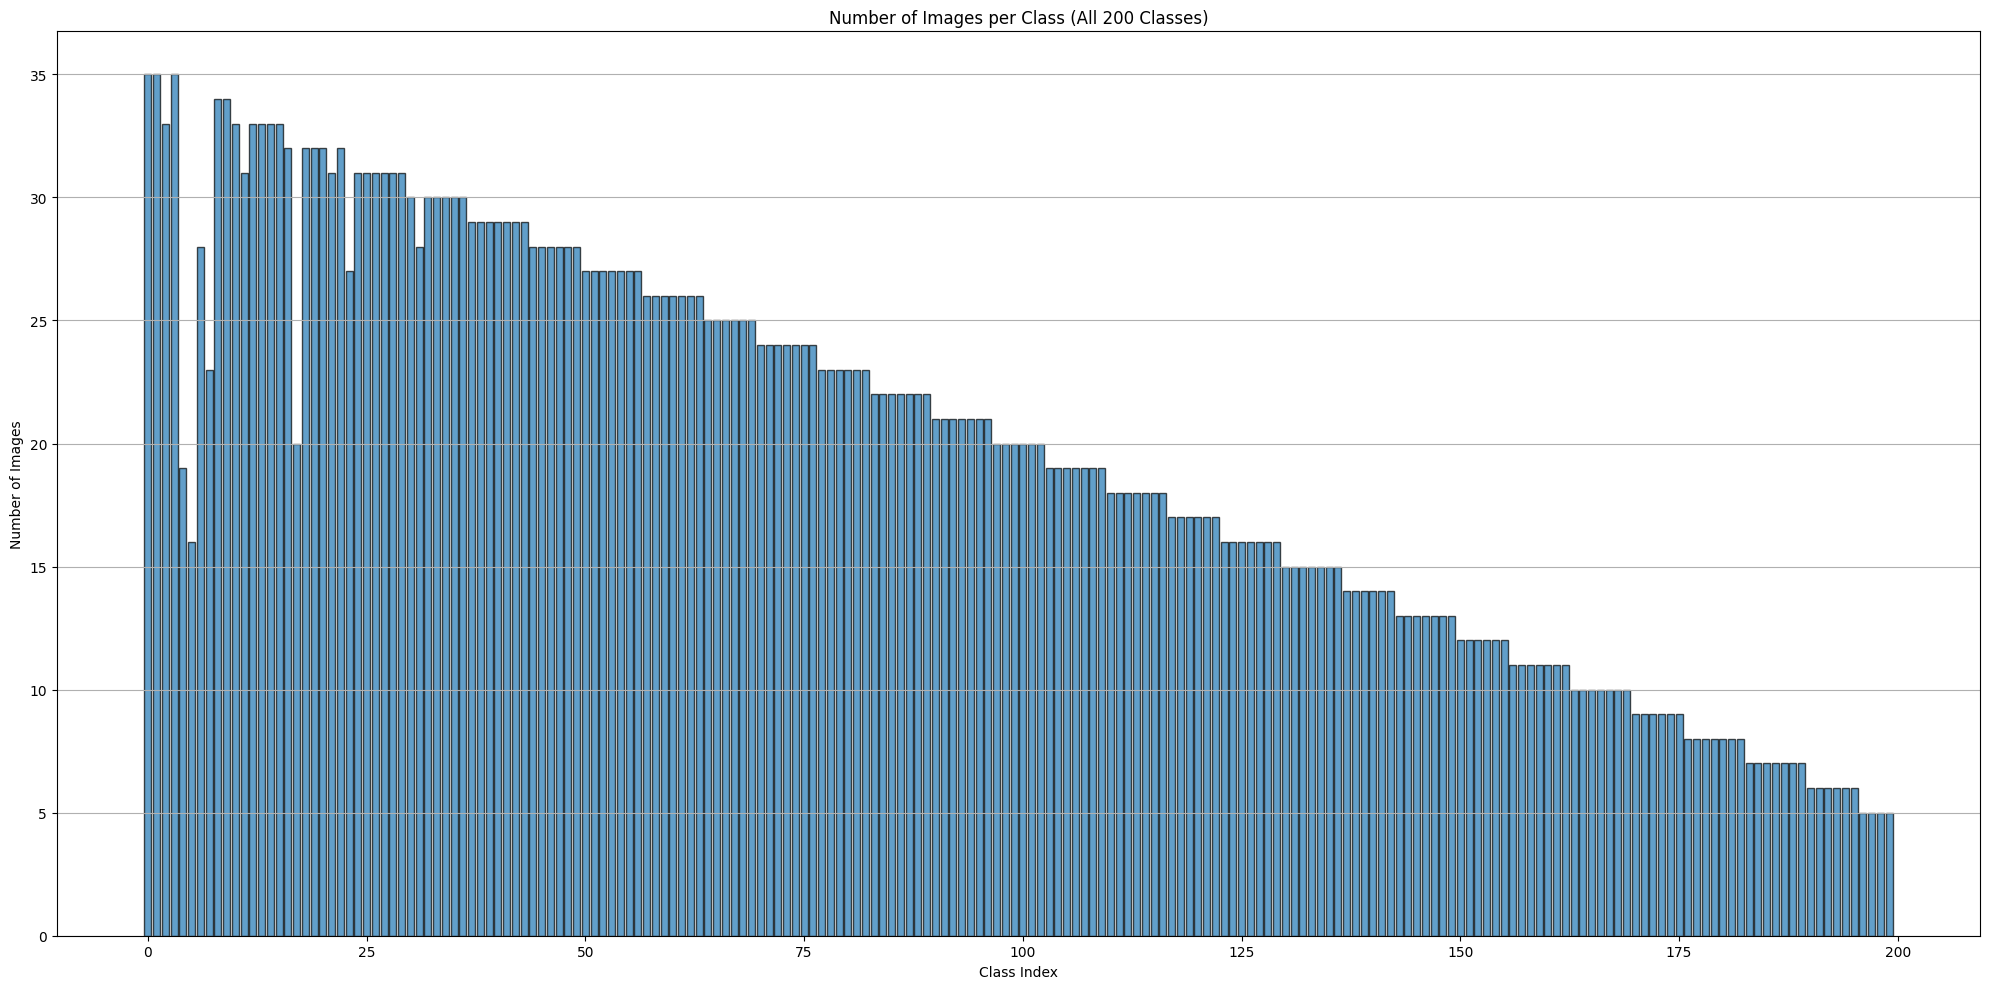

Statistics:
-Number of unique classes: 200
-Average number of images per class: 19.63
-Standard deviation of images per class: 8.39 (Lower the std, more balanced the dataset)
-Minimum number of images per class: 5
-Maximum number of images per class: 35


In [22]:
# Plot the class distribution to inspect the balance
class_counts = train_df['label'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(20, 10))

# Show the count for each class
ax.bar(range(len(class_counts)), class_counts.values, tick_label=None, edgecolor='k', alpha=0.7)
ax.set_xlabel('Class Index')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class (All 200 Classes)')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

# Statistics
print("Statistics:")
print(f"-Number of unique classes: {len(class_names)}")
print(f"-Average number of images per class: {class_counts.mean():.2f}")
print(f"-Standard deviation of images per class: {class_counts.std():.2f} (Lower the std, more balanced the dataset)")
print(f"-Minimum number of images per class: {class_counts.min()}")
print(f"-Maximum number of images per class: {class_counts.max()}")


In [23]:
# Check for Corrupted Images

# Check Training Set
corrupt_counter_train = 0
for idx, row in train_df.iterrows():
    img_path = f"{TRAIN_IMAGES_BASE_PATH}{row['image_path']}"
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        corrupt_counter_train += 1

# Check Test Set
corrupt_counter_test = 0
for idx, row in test_df.iterrows():
    img_path = f"{TEST_IMAGES_BASE_PATH}{row['image_path']}"
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        corrupt_counter_test += 1

# Print the results
print(f"Total corrupt images in training set: {corrupt_counter_train}")
print(f"Total corrupt images in test set: {corrupt_counter_test}")


Total corrupt images in training set: 0
Total corrupt images in test set: 4000


In [9]:
# Check the color stats for all training images
def get_color_stats(image_path):
    img = Image.open(image_path).convert('RGB')
    stat = ImageStat.Stat(img)
    brightness = sum(stat.mean) / len(stat.mean)
    contrast = sum(stat.stddev) / len(stat.stddev)
    saturation = max(stat.mean) - min(stat.mean)
    return brightness, contrast, saturation

stats = [get_color_stats(f"{TRAIN_IMAGES_BASE_PATH}{p}") for p in train_df['image_path']]
brightnesses = [s[0] for s in stats]
contrasts = [s[1] for s in stats]
saturations = [s[2] for s in stats]

print(f"Color Statistics:")
print(f"- Brightness: mean={np.mean(brightnesses):.2f}, std={np.std(brightnesses):.2f}, range=[{min(brightnesses):.2f}, {max(brightnesses):.2f}]")
print(f"- Contrast: mean={np.mean(contrasts):.2f}, std={np.std(contrasts):.2f}, range=[{min(contrasts):.2f}, {max(contrasts):.2f}]")
print(f"- Saturation: mean={np.mean(saturations):.2f}, std={np.std(saturations):.2f}, range=[{min(saturations):.2f}, {max(saturations):.2f}]")
print("\nWISE WORDS FROM THE ML GODS:")
print("- High variance values indicate that our images already have diverse properties.\n- Hence, we don't need to use (high parameters for) ColorJitter.")

Color Statistics:
- Brightness: mean=121.81, std=33.72, range=[18.69, 244.95]
- Contrast: mean=47.22, std=14.21, range=[11.51, 106.21]
- Saturation: mean=32.34, std=25.01, range=[0.00, 178.80]

WISE WORDS FROM THE ML GODS:
- High variance values indicate that our images already have diverse properties.
- Hence, we don't need to use (high parameters for) ColorJitter.


### Split the data into training, validation and test sets

In [10]:
# Extract image paths and labels
X = train_df['image_path'].values
y = train_df['label'].values       

# Look at indices of labels (Y)
print("Before correction:")
print("- y indices min:", y.min())
print("- y indices max:", y.max())

# Since the labels start from 1, convert them to 0-indexed
y = y - 1

print("After correction:")
print("- y indices min:", y.min())
print("- y indices max:", y.max())

# Split the data into training and validation sets (80% train, 20% validation)
X_test = test_df['image_path'].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size = VAL_SPLIT_RATIO, 
    random_state = RANDOM_STATE, # keep the same random state across runs for reproducibility
    stratify = y  # Maintains class distribution in both sets
)

Before correction:
- y indices min: 1
- y indices max: 200
After correction:
- y indices min: 0
- y indices max: 199


### Define the transformations

In [24]:
# Transformations for training set
transformation_training = v2.Compose([

    # Randomly crop to IMAGE_SIZE from a resized area of the image.
    # - Scale controls how much of the original image area we keep (tunable via RANDOM_CROP_SCALE).
    # - Since feathers require fine details, we keep the scale high.
    # - Antialias=True is used to improve the quality of the resized image.
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=RANDOM_CROP_SCALE, antialias=True),
    
    # Random horizontal flip (tunable via HORIZONTAL_FLIP_PROB)
    v2.RandomHorizontalFlip(p=HORIZONTAL_FLIP_PROB), 
    
    # Random rotation (tunable via ROTATION_DEGREES)
    v2.RandomRotation(degrees=ROTATION_DEGREES), 
    
    # Color jitter (tunable via COLOR_JITTER constants)
    # Kept small since the stats of the training images are already diverse.
    # Strong color augmentations can distort the images and make the model more confused.
    v2.ColorJitter(
        brightness=COLOR_JITTER_BRIGHTNESS, 
        contrast=COLOR_JITTER_CONTRAST, 
        saturation=COLOR_JITTER_SATURATION, 
        hue=COLOR_JITTER_HUE
    ), 
    
    # Convert to float32 and scale to [0,1] (also converts to tensor)
    v2.ToDtype(torch.float32, scale=True),
    
    # Normalize the image (ImageNet stats for pretrained models, tunable)
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD), 
])

# Transformations for validation set
transformation_validation = v2.Compose([
    
    # Resize to RESIZE_SIZE (no randomness for consistent validation)
    v2.Resize(RESIZE_SIZE, antialias=True),

    # Center crop to IMAGE_SIZE (matches the training set)
    v2.CenterCrop(IMAGE_SIZE),
    
    # Convert to float32 and scale to [0,1] (also converts to tensor)
    v2.ToDtype(torch.float32, scale=True),
     
    # Normalize the image (must match the training normalization)
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

### Create Custom Dataset for PyTorch

In [25]:
# Pytorch needs a custom dataset to load and transform the data
class FeatherImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transformation=None, target_transformation=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transformation = transformation
        self.target_transformation = target_transformation
    
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, i):
        image_path = self.image_paths[i]
        image_label = self.image_labels[i]  
        image = decode_image(image_path)
        if self.transformation:
            image = self.transformation(image)
        if self.target_transformation:
            image_label = self.target_transformation(image_label)
        return image, image_label

### Create Dataset Instances and DataLoaders

In [26]:
# Create dataset instances with transformations
# Create custom dataset instance for training set
train_dataset = FeatherImageDataset(
    image_paths = [TRAIN_IMAGES_BASE_PATH + path for path in X_train],
    image_labels = y_train,
    transformation = transformation_training
)

# Create custom dataset instance for validation set
val_dataset = FeatherImageDataset(
    image_paths = [TRAIN_IMAGES_BASE_PATH + path for path in X_val],
    image_labels = y_val,
    transformation = transformation_validation
)

# Check device availability
# - If GPU is available, use it
# - If MPS is available, use it (GPU supportfor Apple Silicon)
# - Otherwise, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
if device.type == 'cuda':
    batch_size = BATCH_SIZE_GPU
    num_workers = NUM_WORKERS_GPU # Set to 0 for Jupyter notebooks as they might fail with too many workers
    pin_memory = PIN_MEMORY_GPU  # FYI: Pin memory speeds up the transfer data from CPU RAM to GPU vRAM
elif device.type == 'mps':
    batch_size = BATCH_SIZE_MPS
    num_workers = NUM_WORKERS_MPS
    pin_memory = PIN_MEMORY_MPS  # MPS doesn't support pin_memory
else:
    batch_size = BATCH_SIZE_CPU
    num_workers = NUM_WORKERS_CPU
    pin_memory = PIN_MEMORY_CPU  # Not needed for CPU (since it's used to speed up the transfer data from CPU RAM to GPU vRAM)

# Print the DataLoader configuration
print("DataLoader configuration:")
print(f"- Using device: {device}")
print(f"- Batch size: {batch_size}")
print(f"- Number of workers: {num_workers} (0 = main process, avoids pickling issues in Jupyter)")
print(f"- Pin memory: {pin_memory}")

DataLoader configuration:
- Using device: cuda
- Batch size: 8
- Number of workers: 4 (0 = main process, avoids pickling issues in Jupyter)
- Pin memory: True


In [27]:
# Calculate sample weights for class-balanced sampling
# This addresses class imbalance by oversampling minority classes
print("Calculating class-balanced sample weights...")

# Count samples per class
class_counts = pd.Series(y_train).value_counts().sort_index()

# Calculate weights: inverse of class frequency
# Less frequent classes get higher weights
class_weights = 1.0 / class_counts
print(f"\nClass weight statistics:")
print(f"  Min weight: {class_weights.min():.4f} (most common class)")
print(f"  Max weight: {class_weights.max():.4f} (rarest class)")
print(f"  Mean weight: {class_weights.mean():.4f}")

# Assign a weight to each sample based on its class
sample_weights = [class_weights[label] for label in y_train]

# Create WeightedRandomSampler
# This will oversample minority classes during training
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Allow oversampling (drawing samples multiple times)
)

print(f"\nClass-balanced sampler created:")
print(f"  Total samples per epoch: {len(sample_weights)}")
print(f"  Sampling with replacement: Yes")
print(f"  Effect: Minority classes will be seen more frequently during training")

Calculating class-balanced sample weights...

Class weight statistics:
  Min weight: 0.0357 (most common class)
  Max weight: 0.2500 (rarest class)
  Mean weight: 0.0819

Class-balanced sampler created:
  Total samples per epoch: 3140
  Sampling with replacement: Yes
  Effect: Minority classes will be seen more frequently during training


In [29]:
# Create DataLoader for training set with class-balanced sampling
# NOTE: sampler and shuffle are mutually exclusive - we use sampler instead of shuffle
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=train_sampler,  # Use weighted sampler for class balance (replaces shuffle=True)
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Create DataLoader for validation set (no sampling - keep original distribution)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Don't shuffle validation data: So that each time we use the validation, it's the same
    num_workers=num_workers,
    pin_memory=pin_memory  
)

# Print the final information
print(f"\nSetup:")
print(f"- Train dataset: {len(train_dataset)} samples")
print(f"- Validation dataset: {len(val_dataset)} samples")
print(f"- Batch size: {batch_size}")
print(f"- Training uses class-balanced sampling: Yes ✓")


Setup:
- Train dataset: 3140 samples
- Validation dataset: 786 samples
- Batch size: 8
- Training uses class-balanced sampling: Yes ✓


### Birdy CNN

#### Load data, transform etc.

In [30]:
# Import the model and training functions
from models.birdy_cnn import BirdyCNN
from train import train
from validate import validate

# Define the constants for augmentation
IMAGE_SIZE = 224
NUM_CLASSES = 200
IMAGE_SCALE = (0.8, 1.0)
IMAGE_ROTATION = 10
IMAGE_BRIGHTNESS = 0.2
IMAGE_CONTRAST = 0.2
IMAGE_FLIP = 0.5

# Define augmented transforms for training
transform_aug = v2.Compose([
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=IMAGE_SCALE),
    v2.RandomHorizontalFlip(p=IMAGE_FLIP),
    v2.RandomRotation(degrees=IMAGE_ROTATION),
    v2.ColorJitter(brightness=IMAGE_BRIGHTNESS, contrast=IMAGE_CONTRAST),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

# Create training dataset with augmented transforms
train_dataset_aug = FeatherImageDataset(
    image_paths=[TRAIN_IMAGES_BASE_PATH + path for path in X_train],
    image_labels=y_train,
    transformation=transform_aug
)

# Create DataLoader for training with augmentation AND class-balanced sampling
# Reuse the same train_sampler we created earlier for class balance
train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=batch_size,
    sampler=train_sampler,  # Use weighted sampler for class balance (replaces shuffle=True)
    num_workers=num_workers,
    pin_memory=pin_memory
)

print(f"Augmented training loader created with class-balanced sampling ✓")

Augmented training loader created with class-balanced sampling ✓


#### Run the BIRDY model

In [31]:
# # Initialize the BirdyCNN model
# model = BirdyCNN(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES).to(DEVICE)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# print(f"Using device: {DEVICE}")
# print(f"\nTraining BirdyCNN with augmented transforms...")
# print(f"- Training samples: {len(train_dataset_aug)}")
# print(f"- Validation samples: {len(val_dataset)}")
# print(f"- Batch size: {batch_size}")

# # Train the model
# trained_model = train(
#     model=model,
#     train_loader=train_loader_aug,
#     val_loader=val_loader,
#     criterion=criterion,
#     optimizer=optimizer,
#     device=DEVICE,
#     num_epochs=2
# )

# # Final validation
# final_acc = validate(trained_model, val_loader, DEVICE)
# print(f"\nFinal Validation Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")

### Grid Search

In [ ]:


# Define the hyperparameter grid
param_grid = {
    # Controls the step size during gradient descent. Too high a value can cause instability; too low can slow convergence.
    'learning_rate': [1e-4, 3e-3], # --> TO CHRIS: remove the two values from the middle if it's too much computation
    'batch_size': [16, 64], # Influences training stability and convergence speed --> TO CHRIS: remove 32 if it's too much computation
    'num_epochs': [60], # Determines the number of training epochs
    'optimizer': ['adam', 'sgd'], # Determines the optimizer to use
    'dropout_rate': [0.0,0.3,0.5], # Dropout rate for regularization --> TO CHRIS: remove 0.3 if it's too much computation
    'l2_weight': [1e-5, 1e-2], # L2 regularization weight (weight decay) 
}


# Early stopping patience (set to None to disable early stopping)
EARLY_STOPPING_PATIENCE = 5

# Store results
grid_search_results = []

print(f"Starting Grid Search with Class-Balanced Sampling + Early Stopping...")
print(f"Early Stopping Patience: {EARLY_STOPPING_PATIENCE} (set to None to disable)")
print(f"Total combinations: {len(list(itertools.product(*param_grid.values())))}")
print(f"Parameter grid:")
for key, values in param_grid.items():
    print(f"  {key}: {values}")

# Iterate through all combinations
for idx, params in enumerate(itertools.product(*param_grid.values())):
    lr, batch_size_gs, epochs, opt_name, dropout, l2= params
    start_time = time.time()
    
    try:
        # Create new data loaders with the current batch size
        # Use class-balanced sampling for training loader
        train_loader_gs = DataLoader(
            train_dataset_aug,
            batch_size=batch_size_gs,
            sampler=train_sampler,  # Use weighted sampler for class balance (replaces shuffle=True)
            num_workers=num_workers,
            pin_memory=pin_memory
        )
        
        val_loader_gs = DataLoader(
            val_dataset,
            batch_size=batch_size_gs,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory
        )
        
        # Initialize a model with current hyperparameters
        model_gs = BirdyCNN(
            image_size=IMAGE_SIZE, 
            num_classes=NUM_CLASSES,
            dropout_rate=dropout
        ).to(DEVICE)
        
        # Define criterion
        criterion_gs = nn.CrossEntropyLoss()
        
        # Select optimizer with L2 regularization (or weight_decay for Adam Optimizer)
        if opt_name == 'adam':
            optimizer_gs = torch.optim.Adam(model_gs.parameters(), lr=lr, weight_decay=l2)
        elif opt_name == 'sgd':
            optimizer_gs = torch.optim.SGD(model_gs.parameters(), lr=lr, momentum=0.9, weight_decay=l2)
        
        # Train the model with early stopping
        print(f"Training...")
        trained_model_gs = train(
            model=model_gs,
            train_loader=train_loader_gs,
            val_loader=val_loader_gs,
            criterion=criterion_gs,
            optimizer=optimizer_gs,
            device=DEVICE,
            num_epochs=epochs,
            patience=EARLY_STOPPING_PATIENCE
        )
        
        # Validate
        final_val_acc = validate(trained_model_gs, val_loader_gs, DEVICE)
        
        elapsed_time = time.time() - start_time
        
        # Store results
        result = {
            'learning_rate': lr,
            'batch_size': batch_size_gs,
            'num_epochs': epochs,
            'optimizer': opt_name,
            'dropout_rate': dropout,
            'l2_weight': l2,
            'val_accuracy': final_val_acc,
            'training_time': elapsed_time
        }
        grid_search_results.append(result)
        
        print(f"  ✓ Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
        print(f"  ✓ Training Time: {elapsed_time:.2f}s")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        result = {
            'learning_rate': lr,
            'batch_size': batch_size_gs,
            'num_epochs': epochs,
            'optimizer': opt_name,
            'dropout_rate': dropout,
            'l2_weight': l2,
            'val_accuracy': None,
            'training_time': None,
            'error': str(e)
        }
        grid_search_results.append(result)

print(f"\nGrid Search Completed!")
print(f"Total experiments: {len(grid_search_results)}")


Starting Grid Search with Class-Balanced Sampling + Early Stopping...
Early Stopping Patience: 5 (set to None to disable)
Total combinations: 48
Parameter grid:
  learning_rate: [0.0001, 0.003]
  batch_size: [16, 64]
  num_epochs: [60]
  optimizer: ['adam', 'sgd']
  dropout_rate: [0.0, 0.3, 0.5]
  l2_weight: [1e-05, 0.01]


Training...
Training model for 60 epochs with early stopping...
Epoch 1/60
 Val Acc: 0.0191
Epoch 2/60
 Val Acc: 0.0293
Epoch 3/60
 Val Acc: 0.0496
Epoch 4/60
 Val Acc: 0.0509
Epoch 5/60
 Val Acc: 0.0662
Epoch 6/60
 Val Acc: 0.0738
Epoch 7/60
 Val Acc: 0.0840
Epoch 8/60
 Val Acc: 0.0941
Epoch 9/60
 Val Acc: 0.0992
Epoch 10/60
 Val Acc: 0.0903
Epoch 11/60
 Val Acc: 0.1056
Epoch 12/60
 Val Acc: 0.0980
Epoch 13/60
 Val Acc: 0.1132
Epoch 14/60
 Val Acc: 0.1069
Epoch 15/60
 Val Acc: 0.1196
Epoch 16/60
 Val Acc: 0.1005
Epoch 17/60
 Val Acc: 0.1170
Epoch 18/60
 Val Acc: 0.1221
Epoch 19/60
 Val Acc: 0.1132
Epoch 20/60
 Val Acc: 0.1132
Epoch 21/60
 Val Acc: 0.1094
Epoch 22/6

In [35]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(grid_search_results)

# Sort by validation accuracy (descending)
results_df_sorted = results_df.sort_values('val_accuracy', ascending=False)

print("Grid Search Results:")
print(results_df_sorted.head(10).to_string(index=False))

print(f"\nBest Configuration:")
best_result = results_df_sorted.iloc[0]
for key, value in best_result.items():
    if key == 'val_accuracy' and value is not None:
        print(f"  {key}: {value:.4f} ({value*100:.2f}%)")
    elif key == 'val_loss' and value is not None:
        print(f"  {key}: {value:.4f}")
    elif key == 'training_time' and value is not None:
        print(f"  {key}: {value:.2f}s")
    else:
        print(f"  {key}: {value}")

# Display full results DataFrame
print(f"\n\nAll Results:")
print(results_df_sorted.to_string(index=False))

# Save results to CSV
output_path = 'grid_search_results.csv'
results_df_sorted.to_csv(output_path, index=False)
print(f"Grid search results saved to: {output_path}")

# Display summary statistics
print(f"\n\nSummary Statistics:")
print(results_df[['val_accuracy', 'training_time']].describe())

Grid Search Results:
 learning_rate  batch_size  num_epochs optimizer  dropout_rate  l2_weight  val_accuracy  training_time
        0.0030          16          60       sgd           0.3    0.00001      0.141221     212.063826
        0.0001          16          60      adam           0.5    0.00001      0.129771     128.838949
        0.0030          16          60       sgd           0.5    0.01000      0.124682     200.549498
        0.0001          16          60      adam           0.0    0.00001      0.124682     152.475440
        0.0030          16          60       sgd           0.0    0.00001      0.118321     170.112103
        0.0001          64          60      adam           0.5    0.01000      0.111959     161.957764
        0.0001          16          60      adam           0.3    0.00001      0.105598     138.346419
        0.0001          64          60      adam           0.3    0.00001      0.104326      79.925966
        0.0030          16          60       sgd    

### Apply the best model to test data and export it to kaggle-friendly csv format

In [36]:
# Get the best hyperparameters from grid search results
best_result = results_df_sorted.iloc[0]

print("Training final model with best hyperparameters:")
print(f"  Learning Rate: {best_result['learning_rate']}")
print(f"  Batch Size: {int(best_result['batch_size'])}")
print(f"  Epochs: {int(best_result['num_epochs'])}")
print(f"  Optimizer: {best_result['optimizer']}")
print(f"  Dropout Rate: {best_result['dropout_rate']}")
print(f"  L2 Weight: {best_result['l2_weight']}")
print(f"  Expected Val Accuracy (from grid search): {best_result['val_accuracy']:.4f} ({best_result['val_accuracy']*100:.2f}%)")

# Extract hyperparameters
best_lr = best_result['learning_rate']
best_batch_size = int(best_result['batch_size'])
best_epochs = int(best_result['num_epochs'])
best_optimizer = best_result['optimizer']
best_dropout = best_result['dropout_rate']
best_l2 = best_result['l2_weight']

# Create data loaders with best batch size
train_loader_best = DataLoader(
    train_dataset_aug,
    batch_size=best_batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_loader_best = DataLoader(
    val_dataset,
    batch_size=best_batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Initialize model with best hyperparameters
best_model = BirdyCNN(
    image_size=IMAGE_SIZE,
    num_classes=NUM_CLASSES,
    dropout_rate=best_dropout
).to(DEVICE)

# Define criterion
criterion_best = nn.CrossEntropyLoss()

# Select optimizer with best hyperparameters
if best_optimizer == 'adam':
    optimizer_best = torch.optim.Adam(best_model.parameters(), lr=best_lr, weight_decay=best_l2)
elif best_optimizer == 'sgd':
    optimizer_best = torch.optim.SGD(best_model.parameters(), lr=best_lr, momentum=0.9, weight_decay=best_l2)

# Train the model
print(f"\nTraining best model...")
best_model = train(
    model=best_model,
    train_loader=train_loader_best,
    val_loader=val_loader_best,
    criterion=criterion_best,
    optimizer=optimizer_best,
    device=DEVICE,
    num_epochs=best_epochs,
    patience=EARLY_STOPPING_PATIENCE
)

# Final validation
final_val_acc = validate(best_model, val_loader_best, DEVICE)
print(f"\nBest model trained successfully!")
print(f"   Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

Training final model with best hyperparameters:
  Learning Rate: 0.003
  Batch Size: 16
  Epochs: 60
  Optimizer: sgd
  Dropout Rate: 0.3
  L2 Weight: 1e-05
  Expected Val Accuracy (from grid search): 0.1412 (14.12%)

Training best model...
Training model for 60 epochs with early stopping...
Epoch 1/60
 Val Acc: 0.0051
Epoch 2/60
 Val Acc: 0.0089
Epoch 3/60
 Val Acc: 0.0229
Epoch 4/60
 Val Acc: 0.0305
Epoch 5/60
 Val Acc: 0.0369
Epoch 6/60
 Val Acc: 0.0356
Epoch 7/60
 Val Acc: 0.0509
Epoch 8/60
 Val Acc: 0.0585
Epoch 9/60
 Val Acc: 0.0751
Epoch 10/60
 Val Acc: 0.0802
Epoch 11/60
 Val Acc: 0.0763
Epoch 12/60
 Val Acc: 0.0547
Epoch 13/60
 Val Acc: 0.0802
Epoch 14/60
 Val Acc: 0.1005
Epoch 15/60
 Val Acc: 0.0763
Epoch 16/60
 Val Acc: 0.0840
Epoch 17/60
 Val Acc: 0.0941
Epoch 18/60
 Val Acc: 0.0980
Epoch 19/60
 Val Acc: 0.1018
Epoch 20/60
 Val Acc: 0.0954
Epoch 21/60
 Val Acc: 0.1018
Epoch 22/60
 Val Acc: 0.1043
Epoch 23/60
 Val Acc: 0.1158
Epoch 24/60
 Val Acc: 0.1272
Epoch 25/60
 Val Acc

In [38]:
TEST_IMAGES_BASE_PATH

'data/test_images'

In [39]:
from export import export_model

export_model(
    model=best_model,                 # Use the best model from grid search
    test_df=test_df,                  # DataFrame containing test image paths
    test_images_base_path='data', 
    transform=transform_aug,          # Use the same transform you defined earlier (or a validation one without augmentation)
    device=DEVICE,                    # 'cuda' or 'cpu'
    batch_size=32,            
    output_path="submission_best_model.csv",# Filename for the Kaggle submission
    kaggle_labels_start_at_1=True     # Set to True if class IDs are 1-200, False if 0-199
)

Exporting CNN: 100%|██████████| 125/125 [00:11<00:00, 10.74it/s]

Model submission saved to submission_best_model.csv
